<a href="https://colab.research.google.com/github/Him2001/Scalable-Fault-Diagnosis-in-Generators/blob/main/DANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Him2001/Scalable-Fault-Diagnosis-in-Generators.git


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/FYP

/content/drive/MyDrive/FYP


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense

df = pd.read_csv(r"Train.csv")
X_train = df.drop(['Detection'], axis = 'columns')
y_train = df.Detection
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0)
del df

y_train = y_train.astype('float32')
X_train = X_train.astype('float32')

df1 = pd.read_csv(r"5Overlap.csv")
X_testf= df1.drop(['Detection'], axis = 'columns')
y_testf = df1.Detection

del df1
y_testf = y_testf.astype('float32')
X_testf = X_testf.astype('float32')



In [ ]:
import numpy as np
import tensorflow.keras.utils as np_utils


input_shape = (3000,)
num_classes = 2
source_domain_label = 0
target_domain_label = 1

d_train = np.full(y_train.shape[0], source_domain_label)
y_train = np_utils.to_categorical(y_train)


d_testf = np.full(y_testf.shape[0], target_domain_label)
y_testf = np_utils.to_categorical(y_testf)


In [ ]:
from keras.layers import Input, Dense, Dropout, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K
import matplotlib.colors as mcolors
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import pydot
import tensorflow as tf


# Define the feature extractor function
def build_feature_extractor(input_layer):
    x = Dense(2000, activation='relu')(input_layer)
    x = Dense(1000, activation='relu')(x)
    x = Dense(500, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    feature_extractor = Dense(10, activation='relu')(x)
    return feature_extractor

# Define the label predictor function
def build_label_predictor(feature_extractor, num_classes):
    label_predictor = Dense(num_classes, activation='softmax', name='label_predictor')(feature_extractor)
    return label_predictor


def reverse_gradient(X, coeff):
    """
    Flips the sign of the gradient during training.
    """
    gradient_op = tf.gradients(X, [X])[0] # Use tf.gradients instead of K.gradients
    return X + coeff * gradient_op

# Build the domain classifier
def build_domain_classifier(feature_extractor, coeff=-1.0):
    # Use the custom Lambda layer to apply reverse gradient
    # Explicitly specify the output shape
    dc = Lambda(lambda x: reverse_gradient(x, coeff), output_shape=feature_extractor.shape)(feature_extractor)
    dc = Dense(50, activation='relu')(dc)
    dc = Dense(25, activation='relu')(dc)
    domain_classifier = Dense(1, activation='sigmoid', name='domain_classifier')(dc)
    return domain_classifier


# Define the model function
def build_dann(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    feature_extractor = build_feature_extractor(input_layer)
    label_predictor = build_label_predictor(feature_extractor, num_classes)
    domain_classifier = build_domain_classifier(feature_extractor)
    model = Model(inputs=input_layer, outputs=[label_predictor, domain_classifier])
    return model


# Define the training function
def train(model, X_train, y_train, d_train, X_test, y_test, d_test, num_epochs=10, batch_size=32):
    for epoch in range(num_epochs):
        # Train the model for one epoch
        model.train_on_batch(X_train, [y_train, d_train])

        # Evaluate the model on the test set
        test_loss, test_label_loss, test_domain_loss, test_label_acc, test_domain_acc = model.evaluate(X_test, [y_test, d_test], verbose=0)

        # Print the results for this epoch
        print('Epoch {}/{}: test_loss={:.4f}, test_label_loss={:.4f}, test_domain_loss={:.4f}, test_label_acc={:.4f}, test_domain_acc={:.4f}'.format(epoch+1, num_epochs, test_loss, test_label_loss, test_domain_loss, test_label_acc, test_domain_acc))

def test(model, X_test, y_test, d_test):
    # Evaluate the model on the test set
    test_loss, test_label_loss, test_domain_loss, test_label_acc, test_domain_acc = model.evaluate(X_test, [y_test, d_test], verbose=0)

    # Print the results
    print('Test loss: {:.4f}'.format(test_loss))
    print('Test label loss: {:.4f}'.format(test_label_loss))
    print('Test domain loss: {:.4f}'.format(test_domain_loss))
    print('Test label accuracy: {:.4f}'.format(test_label_acc))
    print('Test domain accuracy: {:.4f}'.format(test_domain_acc))
    return test_label_acc



# Define the optimizer
optimizer = Adam(learning_rate=0.001)
# Define the losses and weights
loss_weights = {'label_predictor': 1, 'domain_classifier': 1}
losses = {'label_predictor': 'categorical_crossentropy', 'domain_classifier': 'binary_crossentropy'}


# Build and train the model
classification_model = build_dann(input_shape, num_classes)
# Compile the model
classification_model.compile(optimizer=optimizer, loss=losses, loss_weights= loss_weights, metrics=['accuracy'])
plot_model(classification_model, to_file='model_summary.png', show_shapes=True, show_layer_names=True)

# Train the model
train(classification_model, X_train, y_train, d_train, X_testf, y_testf, d_testf, num_epochs=25, batch_size = 300)

# Evaluate the model on the test set
accuracy = test(classification_model, X_testf, y_testf, d_testf)



ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(51072, 2, 2), output.shape=(51072, 2)

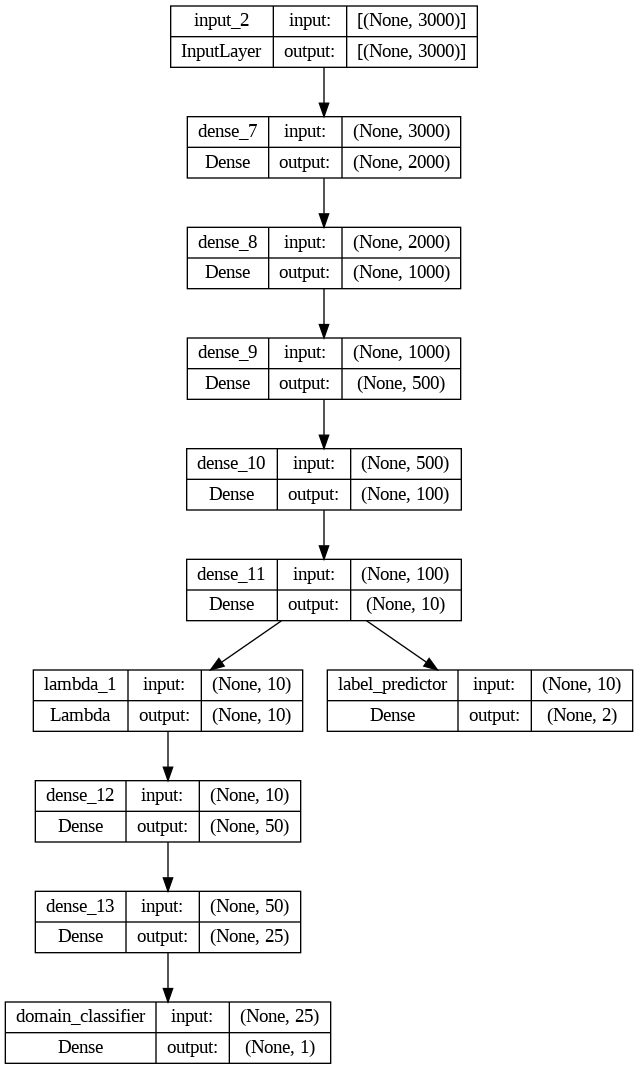

In [ ]:
image_path = 'model_summary.png'

# Display the image in the output
Image(filename=image_path)

In [ ]:
from sklearn.svm import SVC
import numpy as np


X_train = np.array(X_train)
X_testf= np.array(X_testf)
x = classification_model.layers[1](X_train)
x = classification_model.layers[2](x)
x = classification_model.layers[3](x)
x = classification_model.layers[4](x)
X_train_features = classification_model.layers[5](x).numpy()

y = classification_model.layers[1](X_testf)
y = classification_model.layers[2](y)
y = classification_model.layers[3](y)
y = classification_model.layers[4](y)
X_test_features = classification_model.layers[5](y).numpy()

# Apply t-SNE to the extracted features
tsne = TSNE(n_components=2, random_state=0)
X_train_tsne = tsne.fit_transform(X_train_features)
X_test_tsne = tsne.fit_transform(X_test_features)
y_testf = np.argmax(y_testf, axis=1)
y_train = np.argmax(y_train, axis=1)


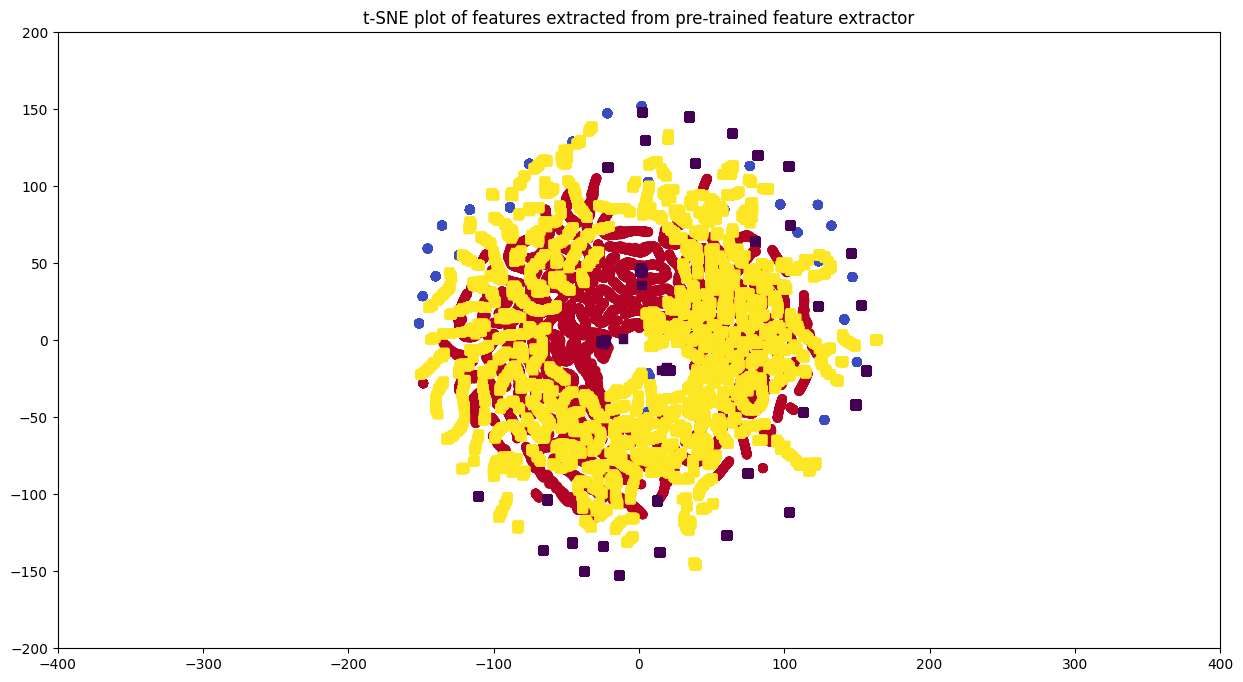

In [ ]:
# plot the decision boundary and the t-SNE plot
plt.figure(figsize=(15,8))


plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train.flatten(), cmap='coolwarm', marker='o')
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_testf.flatten(), cmap='viridis', marker='s')
plt.xlim(-400, 400)
plt.ylim(-200, 200)
plt.show()
